### Sparkify platform

Objective: increase the revenue of the platform

This exercise encourages to use pyspark, I chose python for the simple reason that spark 
is working better with scala and there is computional power issue here (the data is not that heavy).
If we were about using more data, we should obviously think to another solution (pyspark, dask, precomputation) 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import json

## 1. import data

In [14]:
data = pd.read_json("sparkify_data.json", lines=True)

In [15]:
data.shape

(543705, 18)

In [16]:
data.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98


## 2. EDA

In [17]:
data.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId'],
      dtype='object')

In [18]:
print(f"the dataset contains {len(data)} rows")

the dataset contains 543705 rows


In [19]:
#missing values in %
round(data.isna().sum()/len(data)*100,1)

artist           20.4
auth              0.0
firstName         2.9
gender            2.9
itemInSession     0.0
lastName          2.9
length           20.4
level             0.0
location          2.9
method            0.0
page              0.0
registration      2.9
sessionId         0.0
song             20.4
status            0.0
ts                0.0
userAgent         2.9
userId            0.0
dtype: float64

In [20]:
print(f'there are {data.artist.nunique()} artists')
print(f'there are {data.userId.nunique()} users')

there are 21247 artists
there are 449 users


In [21]:
data.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98


In [22]:
#categories features
data.groupby('page')['page'].count()

page
About                          1855
Add Friend                     8087
Add to Playlist               12349
Cancel                           99
Cancellation Confirmation        99
Downgrade                      3811
Error                           519
Help                           3150
Home                          27412
Login                          6011
Logout                         5990
NextSong                     432877
Register                         11
Roll Advert                    7773
Save Settings                   585
Settings                       2964
Submit Downgrade                117
Submit Registration               4
Submit Upgrade                  287
Thumbs Down                    4911
Thumbs Up                     23826
Upgrade                         968
Name: page, dtype: int64

In [23]:
data['churn']= np.where(data['page']=='Cancellation Confirmation', 1, 0)

We see that a user can have different status: paid or free and can navigate through the page and subscribe (submit registration) or cancel their surbscription. To reach our goal of increase the platform revnue. A simple approach would be to prevent customer churn and increase the number of subscriptions. We will focus on prevent churn first (more economical and reachable and long-term solution).

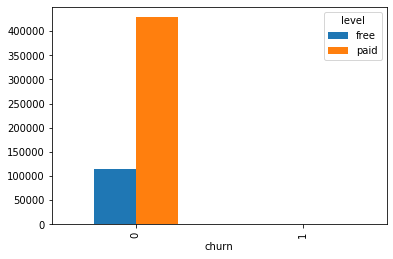

In [24]:
data[['userId','level','churn']].groupby(['level'])['churn'].value_counts().unstack(0).plot.bar()

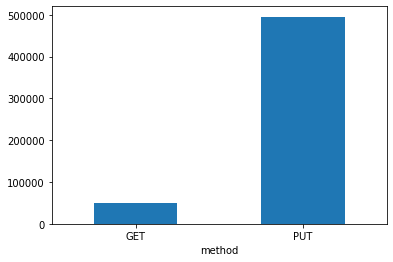

In [25]:
#categories features
ax = data.groupby('method')['page'].count().plot.bar(rot=0)

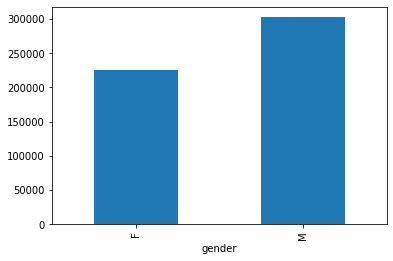

In [26]:
data.groupby('gender')['gender'].count().plot.bar()

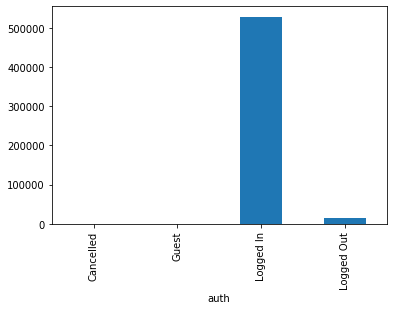

In [27]:
data.groupby('auth')['auth'].count().plot.bar()

In [28]:
# missing values
data.loc[data.isna().sum(axis=1)>4].head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
6,NaN,Logged Out,NaN,NaN,186,NaN,NaN,paid,NaN,GET,Home,NaN,178,NaN,200,1538352148000,NaN,,0
7,NaN,Logged Out,NaN,NaN,187,NaN,NaN,paid,NaN,GET,Home,NaN,178,NaN,200,1538352151000,NaN,,0
8,NaN,Logged Out,NaN,NaN,188,NaN,NaN,paid,NaN,GET,Home,NaN,178,NaN,200,1538352168000,NaN,,0
9,NaN,Logged Out,NaN,NaN,189,NaN,NaN,paid,NaN,PUT,Login,NaN,178,NaN,307,1538352169000,NaN,,0
70,NaN,Logged Out,NaN,NaN,114,NaN,NaN,free,NaN,GET,Home,NaN,442,NaN,200,1538353292000,NaN,,0


In [29]:
#we notice the empty string for UserIDs 
idx = data.loc[data['userId']=='']
print(f'there are {len(idx)} user ids missing')

there are 15700 user ids missing


Users have been using either as guests, free, or paid levels. 
Some of the users, after using the service for a while as paid subscribers end up cancelling their subscription. 
The goal is therefore to be able to predict the churn of such users which here is defined as when a user is tracked in the ‘Cancel Confirmation page’ using the different features measured while the user has been using the platform.

## Feature engineering

In [30]:
#data['ts']= pd.Timestamp(data['ts'], unit='s')
data['ts'] = data['ts'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [6]:
#avg_monthly_session_count
#avg_daily_session_count

In [7]:
#avg_monthly_session_duration
#avg_daily_session_duration

In [8]:
#last_status

In [ ]:
#pages_event_count

def page_event_aggregates(df):
    """
    Calculates monthly, daily averages for each user,for each page event except the ones that include "cancel" 
    :param df: DataFrame
    :return daily and monthly aggregates DataFrame
    """
    
    listOfDistinctPages = [row.page for row in df.select('page').distinct().collect()]
    listOfDistinctPages.remove('Cancel')
    listOfDistinctPages.remove('CancellationConfirmation')
    
    daily_page_event_df = df.groupby('userId','date').pivot('page').count()
    exp_dict={}
    for page in listOfDistinctPages:
        exp_dict.update({page:'mean'})

    daily_page_event_df = daily_page_event_df.join(daily_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')

    for page in listOfDistinctPages:
        daily_page_event_df = daily_page_event_df.drop(page)  
        daily_page_event_df = daily_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_daily_{}'.format(page))

    daily_page_event_df = daily_page_event_df.drop('Cancel','CancellationConfirmation','date').drop_duplicates()
    
    
    monthly_page_event_df = df.groupby('userId','month').pivot('page').count()

    monthly_page_event_df = monthly_page_event_df.join(monthly_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')

    for page in listOfDistinctPages:
        monthly_page_event_df = monthly_page_event_df.drop(page)    
        monthly_page_event_df = monthly_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_monthly_{}'.format(page))

    monthly_page_event_df = monthly_page_event_df.drop('Cancel','CancellationConfirmation','month').drop_duplicates()

    return daily_page_event_df.join(monthly_page_event_df, on='userId')

In [ ]:
#avg_monthly_songs_count
#avg_daily_songs_count

## Preprocessing anf Modeling

In [ ]:
#model

## Predictions